In [ ]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

print(os.uname())

import time
t = time.localtime()
print(f"{t.tm_hour:02d}:{t.tm_min:02d}:{t.tm_sec:02d}")

if locals().get("sliced_dataset") is None:
    print("sliced_dataset is not defined, and hence session was restarted.")
else:
    print("sliced_dataset is already defined, and reusing existing session. No code changes will be imported and reflected in the session!")


## Clustering of 7 s windows of training audio

In [2]:
import pandas as pd

import torch
import torchvision

In [2]:
from ssl_bioacoustics.custom_datasets import AudioDataset

from ssl_bioacoustics.custom_transforms import (
    PreprocessSlidingWindowWithLabels,
    PreprocessSlidingWindowMetadata,
    Spectrogram,
)

# Calculate mel-spectrogram of each sample's 7 s windows, truncating the last window if it's less than 7 s, and padding the first window if it's less than 7 s.
# Then flatten/unroll the spectrogram into a vector for clustering.

sliced_dataset = AudioDataset(
    root_dir="/users/vsharm44/projects/ssl-bioacoustics/data/CBC2020/",
    meta_file="/users/vsharm44/projects/ssl-bioacoustics/data/CBC2020/train.csv",
    split="train",
    sampling_rate=32000,
    transform=torchvision.transforms.v2.Compose([
        Spectrogram(
            sampling_rate=32000,
            representation="power_mel",
            convert_to_db=True,
            representation_mode="grayscale",
            n_mels=128,
            n_fft=2048,
            hop_length=512,
            ),
        torchvision.transforms.v2.ToImage(),
        torchvision.transforms.v2.CenterCrop(size=224),
        torchvision.transforms.v2.ToDtype(dtype=torch.float32, scale=True),
        torchvision.transforms.v2.Lambda(lambda x: torch.flatten(x)),
        ]),
    length=7,
    preprocess_fn=PreprocessSlidingWindowWithLabels(
        window_size=7, hop_length=7, sampling_rate=32000),
    preprocess_metadata_fn=PreprocessSlidingWindowMetadata(
        window_size=7, hop_length=7, individual_length_column_name="duration"),
    preprocessed_cache_dir="/users/vsharm44/projects/ssl-bioacoustics/data/CBC2020/preprocessed_cache",
    reuse_preprocessed_data=True,
    )


In [ ]:
# already preprocessed data when reuse_preprocessed_data=True
print('already preprocessed data:', len(sliced_dataset.meta_data['preprocessed_location']) - sliced_dataset.meta_data['preprocessed_location'].isna().sum())
print('total data:', len(sliced_dataset))

In [ ]:
nan_indices = sliced_dataset.meta_data[sliced_dataset.meta_data['preprocessed_location'].isna()].index.tolist()
print(nan_indices)
for idx in nan_indices:
    x, y = sliced_dataset[idx]

In [ ]:
x, y = sliced_dataset[0]
print(x.shape, y)


In [7]:
from torch.utils.data import DataLoader

dataloader = DataLoader(sliced_dataset, batch_size=1024, shuffle=False, num_workers=64, prefetch_factor=None)


In [ ]:

from sklearn.cluster import MiniBatchKMeans

# clustering logic
n_clusters = 8  # can do "elbow" method to find optimal number of clusters
kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init=20)

y_pred_kmeans = []
for idx, batch in enumerate(dataloader):
    print(f"Processing batch {idx+1} of {len(dataloader)}")
    kmeans = kmeans.partial_fit(batch[0])
    y_pred_kmeans.extend(kmeans.predict(batch[0]))
    print(f"Completed batch {idx+1} of {len(dataloader)}")

y_pred_kmeans = pd.DataFrame({
    "sample_idx": list(range(len(sliced_dataset))),
    "sample": sliced_dataset.meta_data[sliced_dataset.data_column],
    "slice": sliced_dataset.meta_data[sliced_dataset.preprocess_idx_column],
    "cluster": y_pred_kmeans,
    "label": sliced_dataset.meta_data[sliced_dataset.label_column],
    "rating": sliced_dataset.meta_data['rating']
    })


In [17]:
y_pred_kmeans.to_csv("kmeans_clustering_results.csv", index=False)


In [ ]:
import joblib

# Save the trained kmeans model
joblib.dump(kmeans, 'kmeans_model.joblib')


## PCA

In [ ]:
# low dim representation for plotting the Kmeans output in high dim space
import numpy as np
from sklearn.decomposition import PCA

# Initialize PCA with 10 components
pca = PCA(n_components=10)

# Apply PCA on the dataset
pca_features = []
# First collect all data for PCA fitting
all_data = []
for idx, batch in enumerate(dataloader):
    print(f"Collecting batch {idx+1} of {len(dataloader)} for PCA")
    all_data.extend(batch[0].numpy())

# Convert list to numpy array and save
all_data = np.array(all_data)
np.save('input_data.npy', all_data)
del dataloader

# Fit PCA on all data
print("Fitting PCA on all data")
pca_features = pca.fit_transform(all_data)

# Convert to DataFrame
pca_df = pd.DataFrame(
    pca_features, 
    columns=[f'PC{i+1}' for i in range(10)]
)

# Add metadata columns
y_pred_kmeans = pd.read_csv("kmeans_clustering_results.csv")

pca_df['sample_idx'] = y_pred_kmeans['sample_idx']
pca_df['sample'] = y_pred_kmeans['sample']
pca_df['slice'] = y_pred_kmeans['slice']
pca_df['cluster'] = y_pred_kmeans['cluster']
pca_df['label'] = y_pred_kmeans['label']
pca_df['rating'] = y_pred_kmeans['rating']

# Save PCA results
pca_df.to_csv("pca_results.csv", index=False)


In [ ]:
# Save PCA model
from joblib import dump
dump(pca, 'pca_model.joblib')


## Trying different clusters to see if we can find noisy clusters from kmeans clustering.


In [ ]:
import numpy as np
data = np.load('input_data.npy')

In [ ]:
data.shape

In [ ]:
from sklearn.cluster import KMeans
import joblib
from joblib import dump

pca_results = pd.read_csv("pca_kmeans_results/pca_results_8clusters_init20.csv")

clusters_to_try = [8, 16, 32, 64, 128]
# clustering logic
for n_clusters in clusters_to_try:
    kmeans = KMeans(n_clusters=n_clusters)

    print(f"Fitting KMeans with {n_clusters} clusters")
    y_pred_kmeans = kmeans.fit_predict(data)
    print(f"Completed fitting KMeans with {n_clusters} clusters")
    joblib.dump(kmeans, f'kmeans_{n_clusters}clusters.joblib')
    del kmeans

    df = pd.DataFrame({
        "sample_idx": pca_results['sample_idx'],
        "sample": pca_results['sample'],
        "slice": pca_results['slice'],
        "cluster": y_pred_kmeans,
        "label": pca_results['label'],
        "rating": pca_results['rating'],
        "pca_1": pca_results['PC1'],
        "pca_2": pca_results['PC2'],
        "pca_3": pca_results['PC3'],
        "pca_4": pca_results['PC4'],
        "pca_5": pca_results['PC5'],
        "pca_6": pca_results['PC6'],
        "pca_7": pca_results['PC7'],
        "pca_8": pca_results['PC8'],
        "pca_9": pca_results['PC9'],
        "pca_10": pca_results['PC10'],
        })

    df.to_csv(f"pca_kmeans_{n_clusters}clusters.csv", index=False)
    del df




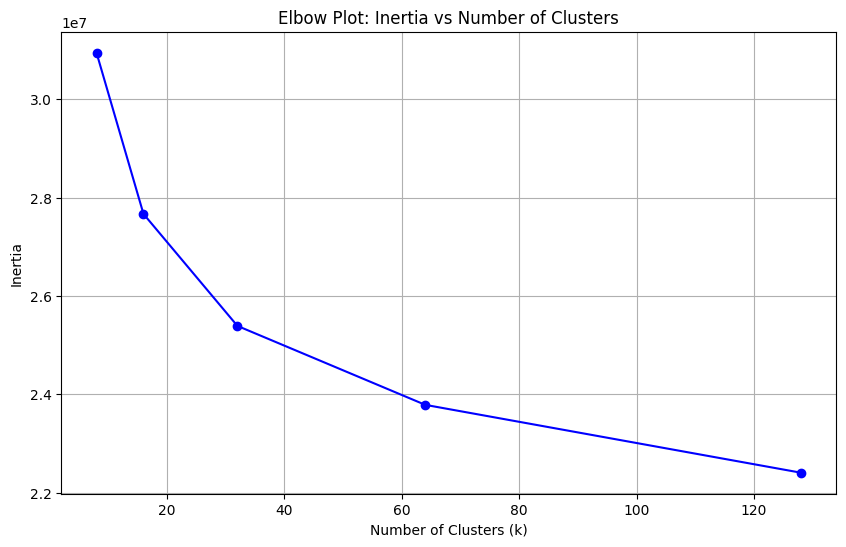

In [2]:
import matplotlib.pyplot as plt
import joblib
from sklearn.cluster import KMeans

# Load all the kmeans models and plot inertia vs k
inertias = []
ks = []

clusters_to_try = [8, 16, 32, 64, 128]

for n_clusters in clusters_to_try:
    kmeans = joblib.load(f'/users/vsharm44/projects/ssl-bioacoustics/pca_kmeans_results/kmeans_{n_clusters}clusters.joblib')
    inertias.append(kmeans.inertia_)
    ks.append(n_clusters)
    
plt.figure(figsize=(10,6))
plt.plot(ks, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot: Inertia vs Number of Clusters')
plt.grid(True)
plt.show()


### Plotting PCA-KMeans Visualizations for different values of K

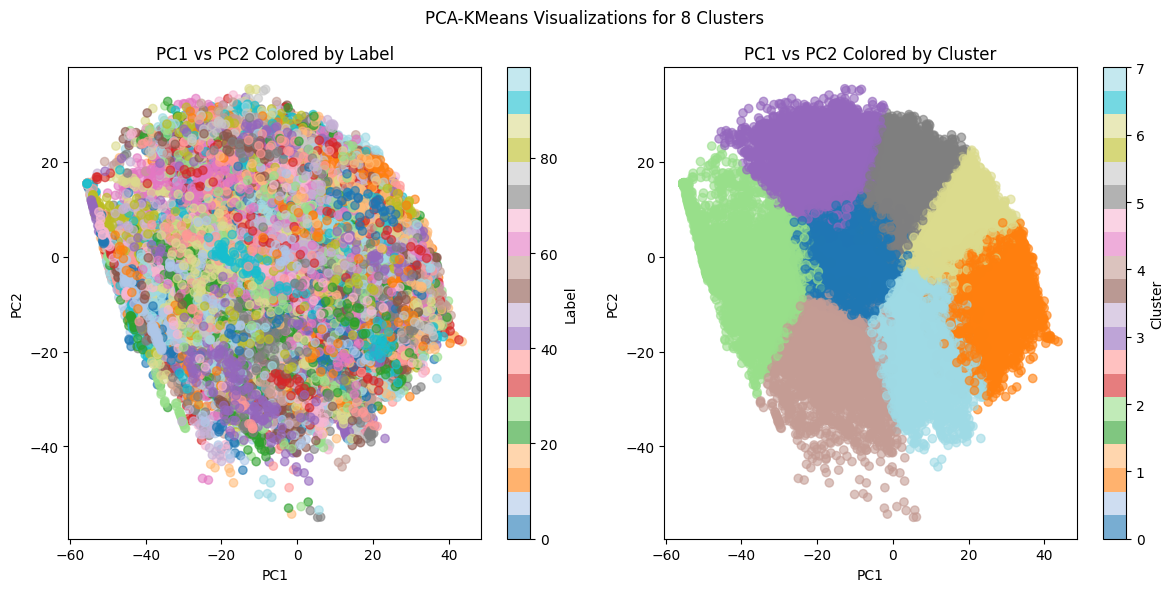

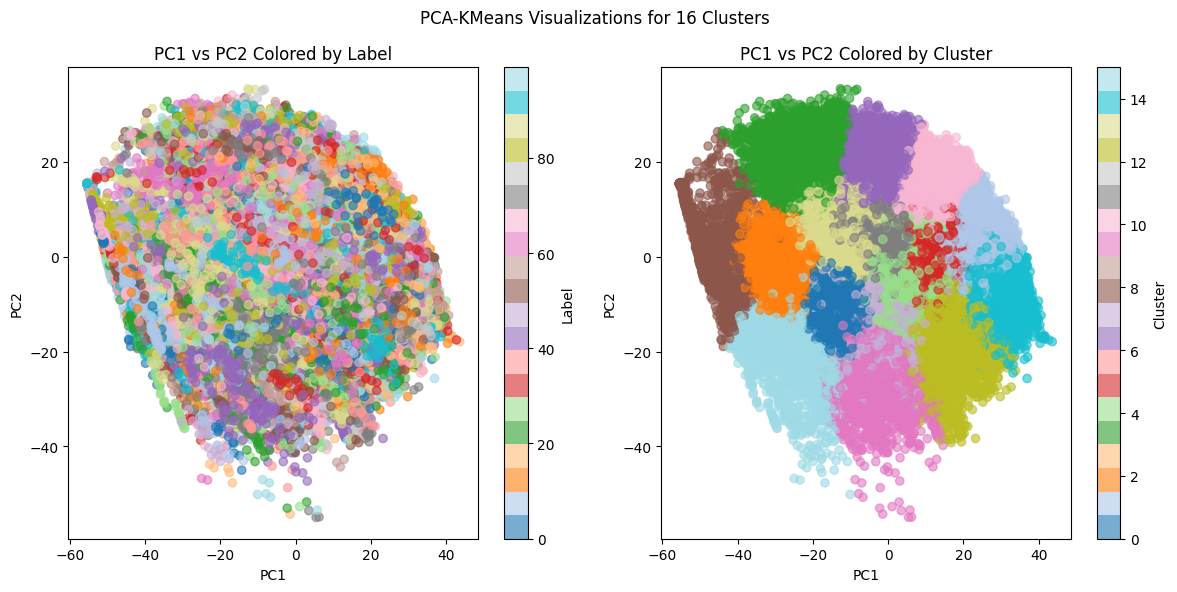

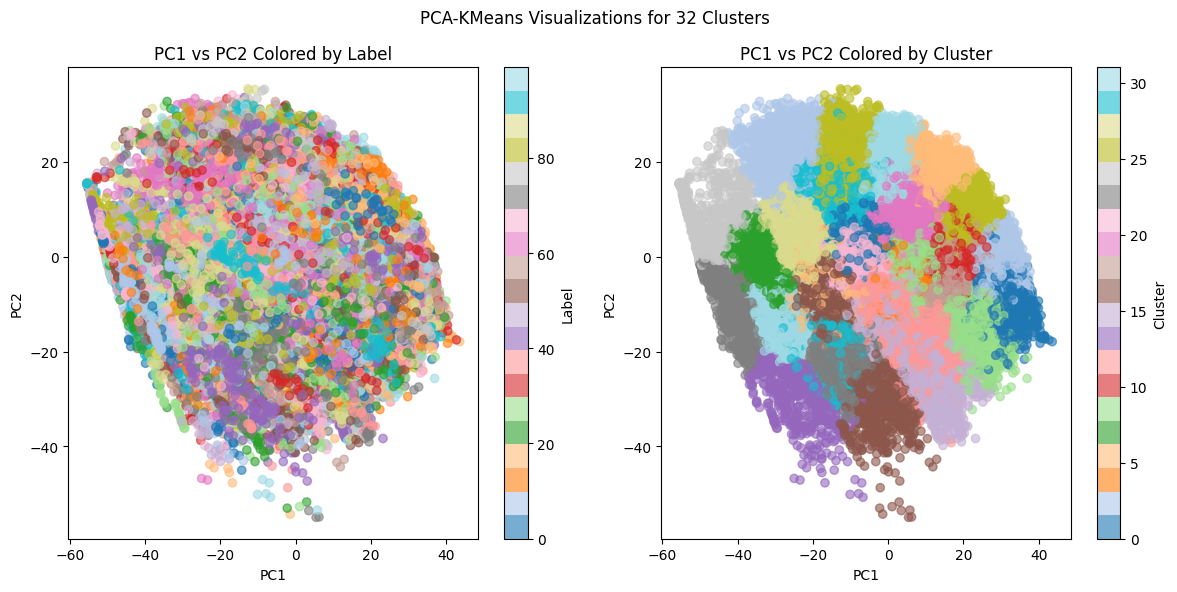

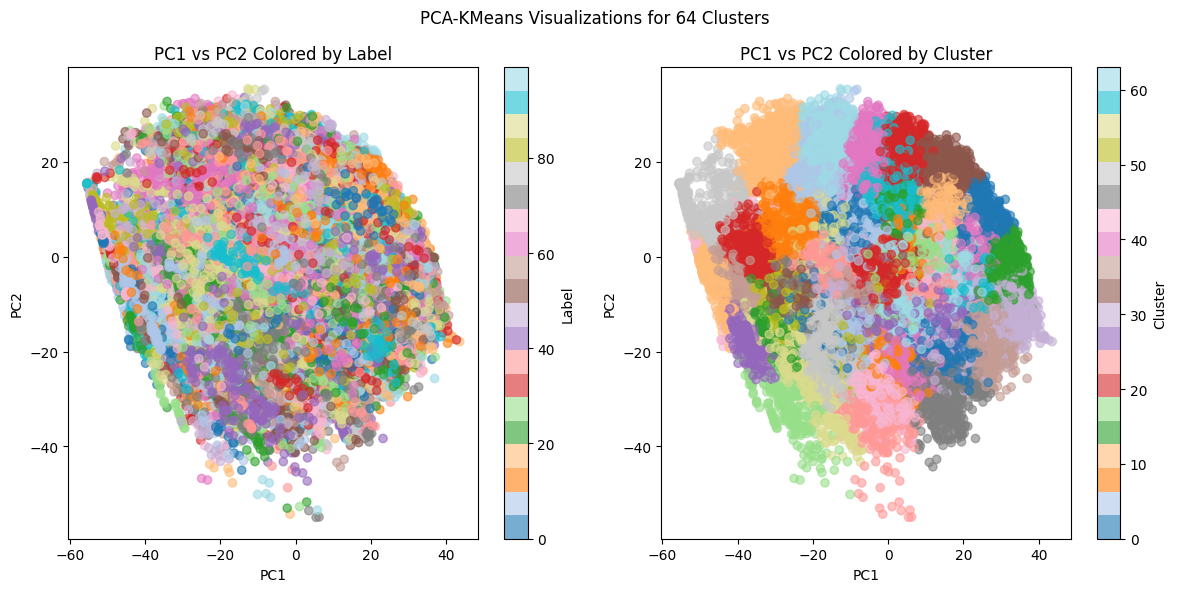

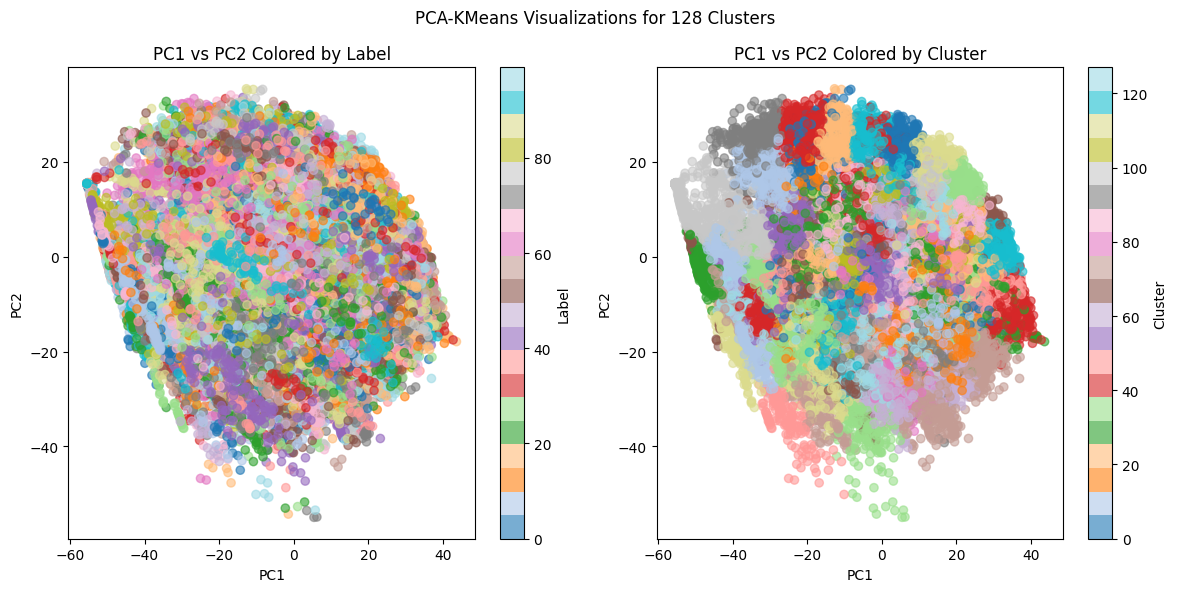

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

for k in [8, 16, 32, 64, 128]:
    plot_data = pd.read_csv(f"/users/vsharm44/projects/ssl-bioacoustics/pca_kmeans_results/pca_kmeans_{k}clusters.csv")
    plot_data.rename(
        columns = {"pca_1": "PC1",
         "pca_2": "PC2",
         }, inplace=True)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    fig.suptitle(f'PCA-KMeans Visualizations for {k} Clusters')
    # Top row - PC1 vs PC2
    scatter1_1 = axes[0].scatter(plot_data['PC1'], plot_data['PC2'], 
                        c=plot_data['label'], cmap='tab20', alpha=0.6)
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    axes[0].set_title('PC1 vs PC2 Colored by Label')
    plt.colorbar(scatter1_1, ax=axes[0], label='Label')

    scatter1_2 = axes[1].scatter(plot_data['PC1'], plot_data['PC2'],
                        c=plot_data['cluster'], cmap='tab20', alpha=0.6)
    axes[1].set_xlabel('PC1') 
    axes[1].set_ylabel('PC2')
    axes[1].set_title('PC1 vs PC2 Colored by Cluster')
    plt.colorbar(scatter1_2, ax=axes[1], label='Cluster')

    plt.tight_layout()
    plt.show()
